In [36]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
from scipy.stats import spearmanr

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from math import sqrt

# Latexify function with fallback fonts
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting."""
    assert(columns in [1,2])
    
    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9  # width in inches
    
    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0
        fig_height = fig_width*golden_mean
    
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        fig_height = MAX_HEIGHT_INCHES
    
    params = {
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'font.size': 10,
        'legend.fontsize': 9,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'figure.figsize': [fig_width, fig_height],
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif'],
        'lines.linewidth': 1,
        'axes.linewidth': 1,
        'patch.linewidth': 0.8,
        'xtick.major.width': 1,
        'ytick.major.width': 1,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
    }
    
    matplotlib.rcParams.update(params)

#### Preprocess

In [3]:
wiki_news_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ2/Dataset/Wiki_News_Data.csv")
wiki_news_df.columns

Index(['city', 'state', 'has_wikipedia', 'wiki_len', 'matched_news_city',
       'media_count'],
      dtype='object')

In [4]:
wiki_news_df.head()

,city,state,has_wikipedia,wiki_len,matched_news_city,media_count
0,agartala,tripura,True,30333,"agartala, tripura",1.0
1,agra,uttar pradesh,True,51925,"agra, uttar pradesh",88.0
2,ahmedabad,gujarat,True,45827,"ahmedabad, gujarat",239.0
3,aizawl,mizoram,True,15347,"aizawl, mizoram",1.0
4,ajmer,rajasthan,True,16162,"ajmer, rajasthan",3.0


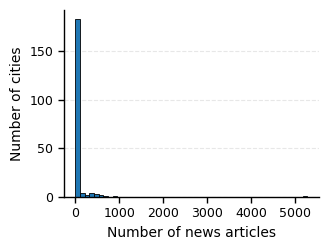

In [4]:
latexify(columns=1, fig_height=2.6)

fig, ax = plt.subplots()

# keep only valid counts
news_counts = wiki_news_df["media_count"].dropna()

ax.hist(
    news_counts,
    bins=50,
    edgecolor="black",
    linewidth=0.6
)

ax.set_xlabel("Number of news articles")
ax.set_ylabel("Number of cities")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.set_axisbelow(True)

fig.tight_layout()
plt.show()

In [5]:
gt_df = pd.read_csv("/home/diya.thakor/AirQuality/Dataset/Ground_Truth_2023_Final.csv")
gt_df.head()

,city,state,YearMonth,AT,BP,PM2.5,RF,VWS,WD,WS,latitude,longitude
0,Agartala,Tripura,2023-01,NaN,750.000000,196.040103,0.044160,NaN,195.440729,0.480669,23.81755,91.272697
1,Agartala,Tripura,2023-02,NaN,750.000000,170.874875,0.000263,NaN,245.936520,0.686900,23.81755,91.272697
2,Agartala,Tripura,2023-03,NaN,750.000000,119.490881,0.009865,NaN,190.550450,0.605829,23.81755,91.272697
3,Agartala,Tripura,2023-04,NaN,749.961354,94.205356,0.027917,NaN,205.834600,0.615330,23.81755,91.272697
4,Agartala,Tripura,2023-05,NaN,749.904747,63.553585,0.015649,NaN,212.567998,0.652385,23.81755,91.272697


In [6]:
gt_df['year'] = pd.to_datetime(gt_df['YearMonth']).dt.year
gt_df['month'] = pd.to_datetime(gt_df['YearMonth']).dt.month_name()
gt_df = gt_df[['city', 'state', 'year', 'month', 'PM2.5']].rename(columns={'PM2.5': 'ground_truth_pm25'})

gt_df.head()

,city,state,year,month,ground_truth_pm25
0,Agartala,Tripura,2023,January,196.040103
1,Agartala,Tripura,2023,February,170.874875
2,Agartala,Tripura,2023,March,119.490881
3,Agartala,Tripura,2023,April,94.205356
4,Agartala,Tripura,2023,May,63.553585


In [7]:
gemma_9b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv")
gemma_27b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv")
llama_8b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_8b_it_2023_predictions.csv")
llama_70b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv")
qwen_14b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_14b_2023_predictions.csv")
qwen_32b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv")
gemini_flash_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemini_flash_2023.csv")
# llama1_70b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_1_70b_it_2023_predictions.csv")
gemini_flash_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemini_flash_2023.csv")
gpt_4o_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gpt_4o_pm25.csv")
cluade_sonnet_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/claude_sonnet_2023.csv")

print(gemma_9b_df.columns)
print(gemma_27b_df.columns)
print(llama_8b_df.columns)
print(llama_70b_df.columns)
print(qwen_14b_df.columns)
print(qwen_32b_df.columns)
print(gemini_flash_df.columns)
print(gpt_4o_df.columns)
print(cluade_sonnet_df.columns)
# print(llama1_70b_df.columns)

Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')


In [38]:
gemma_9b_df.head()

,city,state,year,month,model,pm2.5
0,agartala,tripura,2023,January,google/gemma-2-9b-it,38.7
1,agartala,tripura,2023,February,google/gemma-2-9b-it,35.2
2,agartala,tripura,2023,March,google/gemma-2-9b-it,35.2
3,agartala,tripura,2023,April,google/gemma-2-9b-it,38.7
4,agartala,tripura,2023,May,google/gemma-2-9b-it,38.7


In [8]:
def normalize_city_names(df,key):
    df[key] = df[key].str.strip().str.lower()
    return df

model_dfs = {
    'gemma2-9b-it': gemma_9b_df,
    'llama3.1-8b-Instruct': llama_8b_df,
    # 'llama-3.1-70b': llama1_70b_df,
    "qwen3-14b" : qwen_14b_df,
    'gemma2-27b-it': gemma_27b_df,
    "qwen3-32b" : qwen_32b_df,
    'llama3.3-70b-Instruct': llama_70b_df,
    "gemini-2.5-flash" : gemini_flash_df,
    "gpt-4o" : gpt_4o_df,
    "claude-sonet-4.5" : cluade_sonnet_df
}

wiki_news_df = normalize_city_names(wiki_news_df,'city')
gt_df = normalize_city_names(gt_df,'city')

wiki_news_df = normalize_city_names(wiki_news_df,'state')
gt_df = normalize_city_names(gt_df,'state')

for key in model_dfs:
    model_dfs[key] = normalize_city_names(model_dfs[key], 'city')
    model_dfs[key] = normalize_city_names(model_dfs[key], 'state')

In [9]:
import numpy as np

def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstrap=1000, alpha=0.05, random_state=0):
    """
    Generic non-parametric bootstrap CI for a scalar metric.
    metric_fn: function(y_true, y_pred) -> float
    Returns (lower, upper, std_boot).
    """
    rng = np.random.default_rng(random_state)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)

    stats = []
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, size=n)
        stats.append(metric_fn(y_true[idx], y_pred[idx]))
    stats = np.array(stats)

    lower = np.percentile(stats, 100 * alpha / 2)
    upper = np.percentile(stats, 100 * (1 - alpha / 2))
    return lower, upper, stats.std(ddof=1)

In [10]:
def compute_metrics(df, n_bootstrap=1000, alpha=0.05):
    if df.empty:
        return {
            'MAE': np.nan,
            'MAEtol': np.nan,
            'MAEunder': np.nan,
            'MAEover': np.nan,
            'Over %': np.nan,
            'Under %': np.nan,
            'Samples': 0,
            'Cities': 0,
            # uncertainty fields
            'MAE_se': np.nan,
            'MAE_ci_low_param': np.nan,
            'MAE_ci_high_param': np.nan,
            'MAE_ci_low_boot': np.nan,
            'MAE_ci_high_boot': np.nan,
            'MAE_std_boot': np.nan,
        }

    gt = df['ground_truth_pm25'].to_numpy()
    pred = df['pm2.5'].to_numpy()
    
    abs_error = np.abs(gt - pred)
    mae = abs_error.mean()

    # --- MAE_tolerance etc. (unchanged) ---
    tolerance = 0.10 * gt
    mask_tol = abs_error > tolerance
    maetol = abs_error[mask_tol].mean() if mask_tol.any() else np.nan
    
    under_mask = pred < gt
    over_mask = pred > gt

    maeunder = np.abs(gt[under_mask] - pred[under_mask]).mean() if under_mask.any() else np.nan
    maeover  = np.abs(pred[over_mask] - gt[over_mask]).mean() if over_mask.any() else np.nan
    
    total = len(df)
    over_pct = 100 * over_mask.sum() / total
    under_pct = 100 * under_mask.sum() / total

    # ==============================
    # Uncertainty for MAE
    # 1) SE
    # 2) Parametric CI from SE
    # 3) Bootstrap CI
    # ==============================
    if total > 1:
        # 1) standard error of MAE (treat MAE as mean of |error|)
        mae_se = abs_error.std(ddof=1) / np.sqrt(total)

        # 2) parametric 95% CI using normal approximation
        z = 1.96  # for 95%
        mae_ci_low_param = mae - z * mae_se
        mae_ci_high_param = mae + z * mae_se

        # 3) bootstrap CI
        if n_bootstrap and total > 5:
            mae_ci_low_boot, mae_ci_high_boot, mae_std_boot = bootstrap_ci(
                lambda a, b: np.mean(np.abs(a - b)),
                gt, pred,
                n_bootstrap=n_bootstrap,
                alpha=alpha,
            )
        else:
            mae_ci_low_boot = mae_ci_high_boot = mae_std_boot = np.nan
    else:
        mae_se = mae_ci_low_param = mae_ci_high_param = np.nan
        mae_ci_low_boot = mae_ci_high_boot = mae_std_boot = np.nan

    return {
        'MAE': mae,
        'MAEtol': maetol,
        'MAEunder': maeunder,
        'MAEover': maeover,
        'Over %': over_pct,
        'Under %': under_pct,
        'Samples': total,
        'Cities': df['city'].nunique(),
        # uncertainty fields for plotting
        'MAE_se': mae_se,
        'MAE_ci_low_param': mae_ci_low_param,
        'MAE_ci_high_param': mae_ci_high_param,
        'MAE_ci_low_boot': mae_ci_low_boot,
        'MAE_ci_high_boot': mae_ci_high_boot,
        'MAE_std_boot': mae_std_boot,
    }


#### Wikipedia

In [ ]:
import pandas as pd

# Define bins and labels
bins = [-1, 0, 1000, 5000, 10000, 30000, 70000]
labels = ['No Wiki (0)', '1-1000', '1001-5000', '5001-10000', '10001-30000', '30001-70000']

# Create wiki_len_bin column
wiki_news_df['wiki_len_bin'] = pd.cut(wiki_news_df['wiki_len'], bins=bins, labels=labels)

# Count unique cities in each bin
bin_counts = wiki_news_df.groupby('wiki_len_bin',observed=False)['city'].nunique().reset_index(name='city_count')

print(bin_counts)

In [ ]:
rows = []

for model_name, model_df in model_dfs.items():
    merged = pd.merge(model_df, gt_df, on=['city', 'state', 'year', 'month'], how='inner')
    merged = pd.merge(merged, wiki_news_df, on=['city', 'state'], how='left')
    merged = merged.dropna(subset=['ground_truth_pm25', 'pm2.5'])

    print(merged.shape)

    print("Wiki-present sample count:", (merged['has_wikipedia'] == True).sum())
    print("Wiki-absent sample count:", (merged['has_wikipedia'] != True).sum())

    
    wiki_df = merged[merged['has_wikipedia'] == True]
    non_wiki_df = merged[merged['has_wikipedia'] != True]

    wiki_metrics = compute_metrics(wiki_df)
    non_wiki_metrics = compute_metrics(non_wiki_df)
    
    row = {'Model': model_name}
    for k, v in wiki_metrics.items():
        row[f'With Wiki: {k}'] = v
    for k, v in non_wiki_metrics.items():
        row[f'Without Wiki: {k}'] = v

    rows.append(row)

final_wiki_df = pd.DataFrame(rows)

In [ ]:
final_wiki_df

#### Media presence impact

In [37]:
import seaborn as sns

NEWS_COUNT_THRESHOLD = 0
all_model_errors = []
metrics_rows = []

for model_name, model_df in model_dfs.items():
    # Merge Predictions with Ground Truth
    merged = pd.merge(
        model_df, 
        gt_df, 
        on=['city', 'state', 'year', 'month'], 
        how='inner'
    )
    # Merge with News Data
    merged = pd.merge(
        merged, 
        wiki_news_df, 
        on=['city', 'state'], 
        how='left'
    )
    
    # Clean data
    merged = merged.dropna(subset=['ground_truth_pm25', 'pm2.5'])
    merged['media_count'] = merged['media_count'].fillna(0)

    # Raw absolute error (not used for CIs, but keeps old long-format structure)
    merged['abs_error'] = (merged['pm2.5'] - merged['ground_truth_pm25']).abs()

    # Assign Group
    merged['Media Presence Group'] = np.where(
        merged['media_count'] > NEWS_COUNT_THRESHOLD, 
        'High News', 
        'Low News'
    )
    merged['Model'] = model_name

    # Keep long-format error data (for any other analysis)
    all_model_errors.append(
        merged[['Model', 'abs_error', 'Media Presence Group', 'city']]
    )

    # --- NEW: compute metrics & CIs per (Model, Group) ---
    for group_name, group_df in merged.groupby('Media Presence Group'):
        metrics = compute_metrics(group_df)  # uses SE, param CI, bootstrap CI

        metrics_rows.append({
            'Model': model_name,
            'Media Presence Group': group_name,
            'MAE': metrics['MAE'],
            'MAE_se': metrics['MAE_se'],
            'MAE_ci_low_param': metrics['MAE_ci_low_param'],
            'MAE_ci_high_param': metrics['MAE_ci_high_param'],
            'MAE_ci_low_boot': metrics['MAE_ci_low_boot'],
            'MAE_ci_high_boot': metrics['MAE_ci_high_boot'],
            'Samples': metrics['Samples'],
            'Cities': metrics['Cities'],
        })

# Long-format errors (like before, if you still need it)
news_stats_long = pd.concat(all_model_errors, ignore_index=True)

# Compact metrics table
metrics_df = pd.DataFrame(metrics_rows)
metrics_df = metrics_df.dropna(subset=['MAE'])

In [38]:
# MAE difference (Low - High) per model
pivot_diff = metrics_df.pivot(
    index="Model",
    columns="Media Presence Group",
    values="MAE"
)
pivot_diff["MAE_Difference"] = pivot_diff["Low News"] - pivot_diff["High News"]

metrics_df = metrics_df.merge(
    pivot_diff["MAE_Difference"],
    on="Model",
    how="left"
)

# consistent model order (you can also use metrics_df["Model"].unique())
model_order = list(model_dfs.keys())
metrics_df["Model"] = pd.Categorical(
    metrics_df["Model"],
    categories=model_order,
    ordered=True
)
metrics_df = metrics_df.sort_values("Model")

In [39]:
def plot_news_mae_single_uncertainty(
    metrics_df,
    wiki_news_df,
    err_type="se",
    news_count_threshold=0,
    save_path=None,
):
    df = metrics_df.copy()

    groups = ["High News", "Low News"]
    colors = {
        "High News": "#3D5A7B",
        "Low News": "#A94E4E",
    }

    # model order (fixed)
    model_order = list(df["Model"].cat.categories)
    df = df.sort_values("Model")

    x = np.arange(len(model_order))
    width = 0.8 / len(groups)

    # legend labels
    n_high = wiki_news_df[
        wiki_news_df["media_count"] > news_count_threshold
    ]["city"].nunique()
    n_low = wiki_news_df[
        wiki_news_df["media_count"] <= news_count_threshold
    ]["city"].nunique()

    legend_labels = {
        "High News": f"With News (n={n_high})",
        "Low News":  f"Without News (n={n_low})",
    }

    # uncertainty selector
    def get_error(g):
        mean = g["MAE"].to_numpy()

        if err_type == "se":
            err = g["MAE_se"].to_numpy()
            return err, err
        elif err_type == "param_ci":
            low = g["MAE_ci_low_param"].to_numpy()
            high = g["MAE_ci_high_param"].to_numpy()
        elif err_type == "boot_ci":
            low = g["MAE_ci_low_boot"].to_numpy()
            high = g["MAE_ci_high_boot"].to_numpy()
        else:
            raise ValueError("Invalid err_type")

        return mean - low, high - mean

    # Y-axis limits
    if err_type == "se":
        y_max = np.nanmax(df["MAE"] + df["MAE_se"])
    elif err_type == "param_ci":
        y_max = np.nanmax(df["MAE_ci_high_param"])
    else:
        y_max = np.nanmax(df["MAE_ci_high_boot"])

    y_offset = y_max * 0.03

    fig, ax = plt.subplots(1, 1)

    # ---------- Bars ----------
    for i_group, group in enumerate(groups):
        g = df[df["Media Presence Group"] == group]
        g = g.set_index("Model").loc[model_order]

        xpos = x - 0.4 + i_group * width + width / 2
        heights = g["MAE"].to_numpy()
        err_low, err_high = get_error(g)

        ax.bar(
            xpos,
            heights,
            width,
            label=legend_labels[group],
            color=colors[group],
            edgecolor="black",
            linewidth=0.6,
        )

        ax.errorbar(
            xpos,
            heights,
            yerr=np.vstack([err_low, err_high]),
            fmt="none",
            capsize=3,
            color="black",
            linewidth=1.0,
            zorder=5,
        )

        # numeric labels
        for xp, h, el, eh in zip(xpos, heights, err_low, err_high):
            ax.text(xp, h + eh + y_offset, f"{h:.1f}", ha="center")

    ax.set_xticks(x)
    ax.set_xticklabels(model_order)
    ax.set_ylabel("MAE (µg/m³)")
    ax.set_xlabel("Model")

    # Difference annotations (Low − High)
    max_mae_simple = df["MAE"].max()
    for i, model_name in enumerate(model_order):
        diff = df.loc[df["Model"] == model_name, "MAE_Difference"].iloc[0]
        ax.text(
            i,
            max_mae_simple * 0.02,
            f"Diff: +{diff:.1f}",
            ha="center",
            color="white",
        )

    ax.legend(title="Media presence group", frameon=False)

    # styling
    ax.set_ylim(0, y_max * 1.35)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.set_axisbelow(True)

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, format="pdf", bbox_inches="tight")

    plt.show()


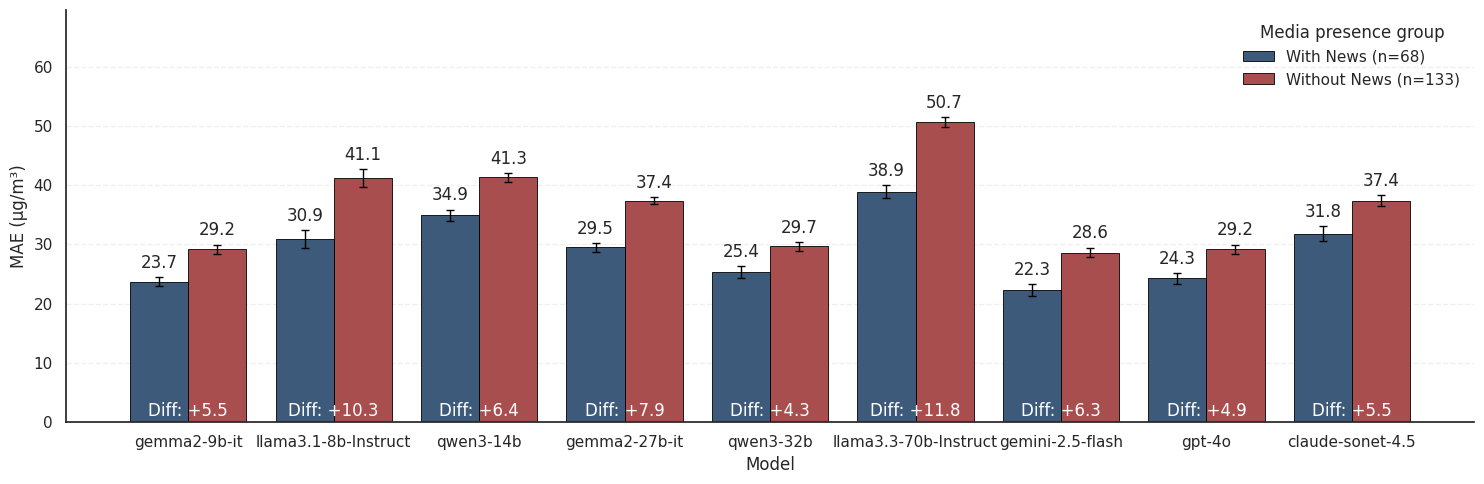

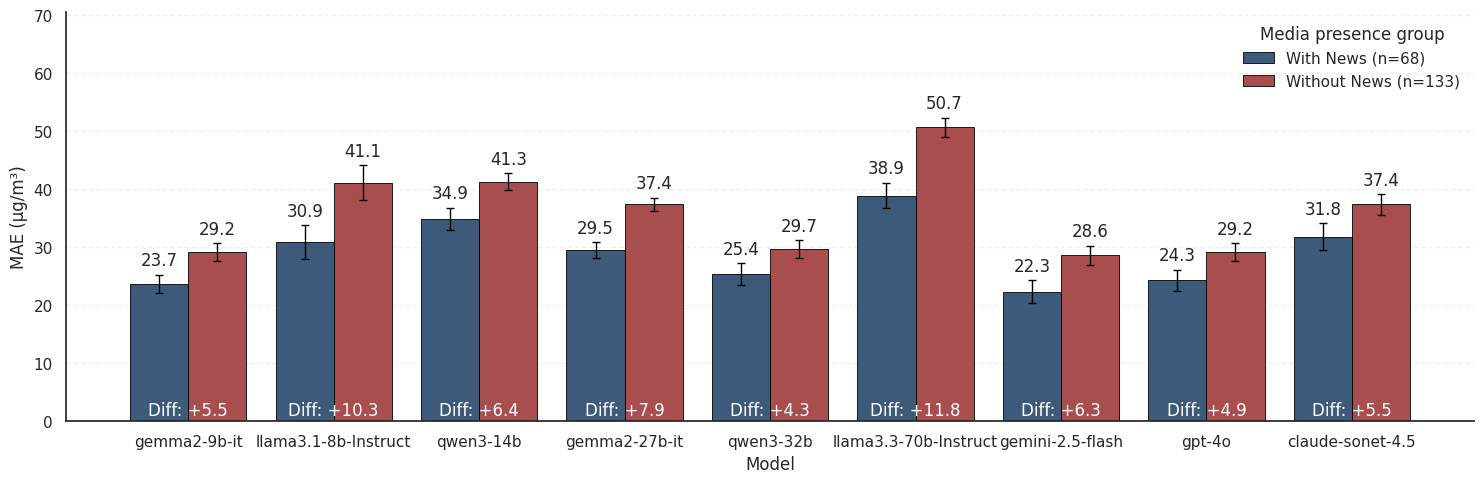

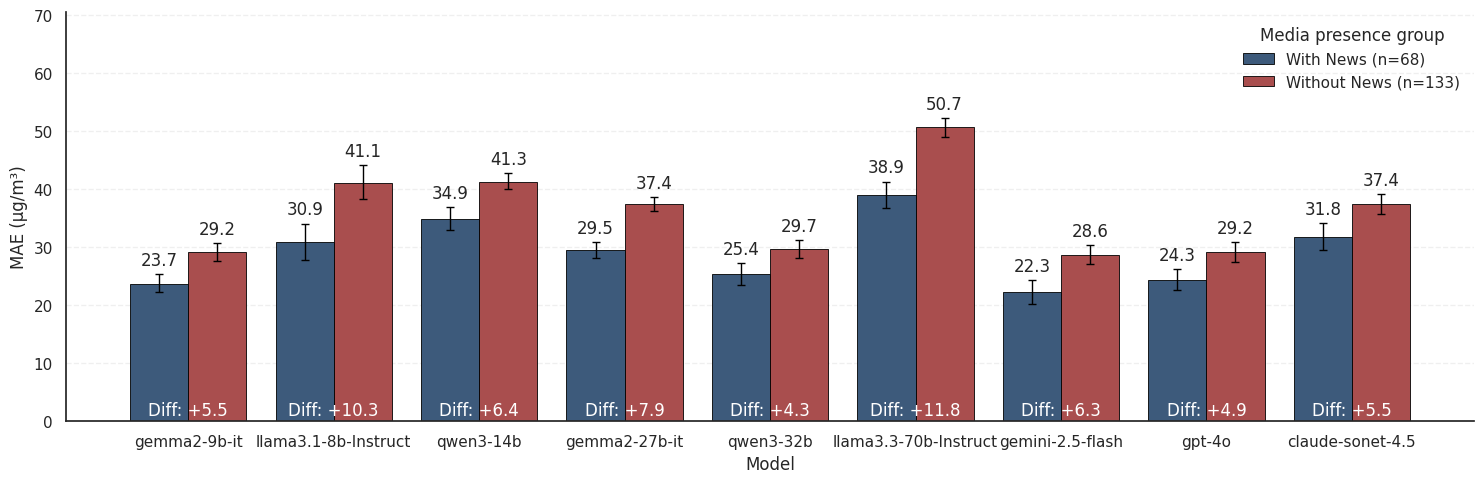

In [43]:
latexify(columns=2, fig_height=5.0, fig_width=15)
sns.set_theme(style="white")

# 1) MAE ± SE
plot_news_mae_single_uncertainty(
    metrics_df,
    wiki_news_df,
    err_type="se",
    news_count_threshold=NEWS_COUNT_THRESHOLD,
    save_path="media_mae_se.pdf",
)

# 2) MAE with parametric 95% CI
plot_news_mae_single_uncertainty(
    metrics_df,
    wiki_news_df,
    err_type="param_ci",
    news_count_threshold=NEWS_COUNT_THRESHOLD,
    save_path="media_mae_ci.pdf",
)

# 3) MAE with bootstrap 95% CI
plot_news_mae_single_uncertainty(
    metrics_df,
    wiki_news_df,
    err_type="boot_ci",
    news_count_threshold=NEWS_COUNT_THRESHOLD,
    save_path="media_mae_boot_ci.pdf",
)

In [40]:
def plot_news_mae_mean_band(
    metrics_df,
    wiki_news_df,
    err_type="se",
    news_count_threshold=0,
    save_path=None,
):
    df = metrics_df.copy()

    groups = ["High News", "Low News"]
    colors = {
        "High News": "#3D5A7B",
        "Low News": "#A94E4E",
    }

    # model order
    model_order = list(df["Model"].cat.categories)
    df = df.sort_values("Model")
    x = np.arange(len(model_order))

    # legend labels (same logic as bar plot)
    n_high = wiki_news_df[
        wiki_news_df["media_count"] > news_count_threshold
    ]["city"].nunique()
    n_low = wiki_news_df[
        wiki_news_df["media_count"] <= news_count_threshold
    ]["city"].nunique()

    legend_labels = {
        "High News": f"With News (n={n_high})",
        "Low News":  f"Without News (n={n_low})",
    }

    # how to get band per group
    def get_band(g):
        mean = g["MAE"].to_numpy()

        if err_type == "se":
            se = g["MAE_se"].to_numpy()
            y_low = mean - se
            y_high = mean + se
        elif err_type == "param_ci":
            y_low = g["MAE_ci_low_param"].to_numpy()
            y_high = g["MAE_ci_high_param"].to_numpy()
        elif err_type == "boot_ci":
            y_low = g["MAE_ci_low_boot"].to_numpy()
            y_high = g["MAE_ci_high_boot"].to_numpy()
        else:
            raise ValueError("Invalid err_type")

        return mean, y_low, y_high

    # y-limits to match bar plot behaviour
    if err_type == "se":
        y_max = np.nanmax(df["MAE"] + df["MAE_se"])
    elif err_type == "param_ci":
        y_max = np.nanmax(df["MAE_ci_high_param"])
    else:
        y_max = np.nanmax(df["MAE_ci_high_boot"])
    y_offset = y_max * 0.03

    fig, ax = plt.subplots(1, 1)

    for group in groups:
        g = df[df["Media Presence Group"] == group]
        g = g.set_index("Model").loc[model_order]

        y_mean, y_low, y_high = get_band(g)

        ax.plot(
            x,
            y_mean,
            marker="o",
            linestyle="-",
            color=colors[group],
            label=legend_labels[group],
        )

        ax.fill_between(
            x,
            y_low,
            y_high,
            color=colors[group],
            alpha=0.25,
        )

        # optional numeric labels above mean
        for xp, m, hi in zip(x, y_mean, y_high):
            ax.text(xp, hi + y_offset, f"{m:.1f}", ha="center")

    ax.set_xticks(x)
    ax.set_xticklabels(model_order)
    ax.set_ylabel("MAE (µg/m³)")
    ax.set_xlabel("Model")

    ax.legend(title="Media presence group", frameon=False)

    ax.set_ylim(0, y_max * 1.35)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.set_axisbelow(True)

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, format="pdf", bbox_inches="tight")

    plt.show()

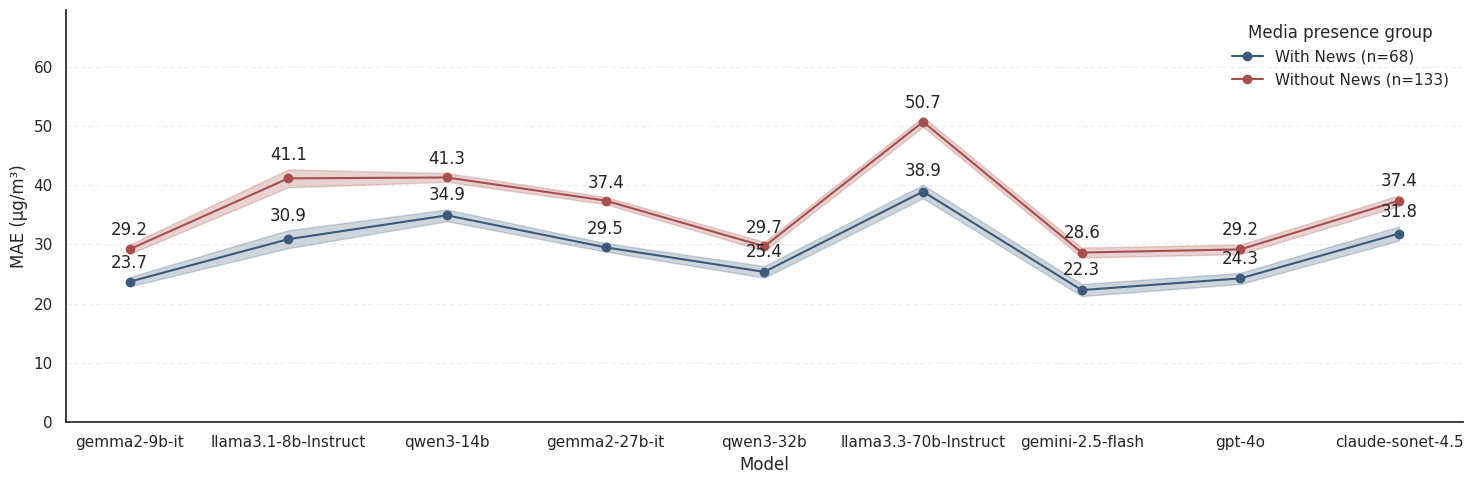

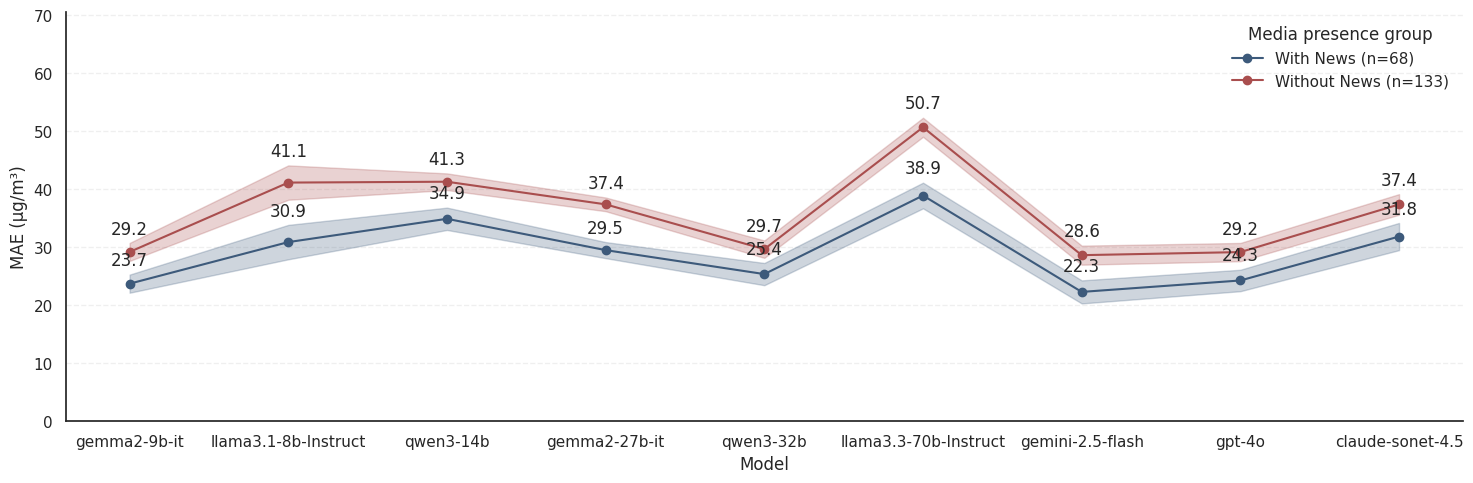

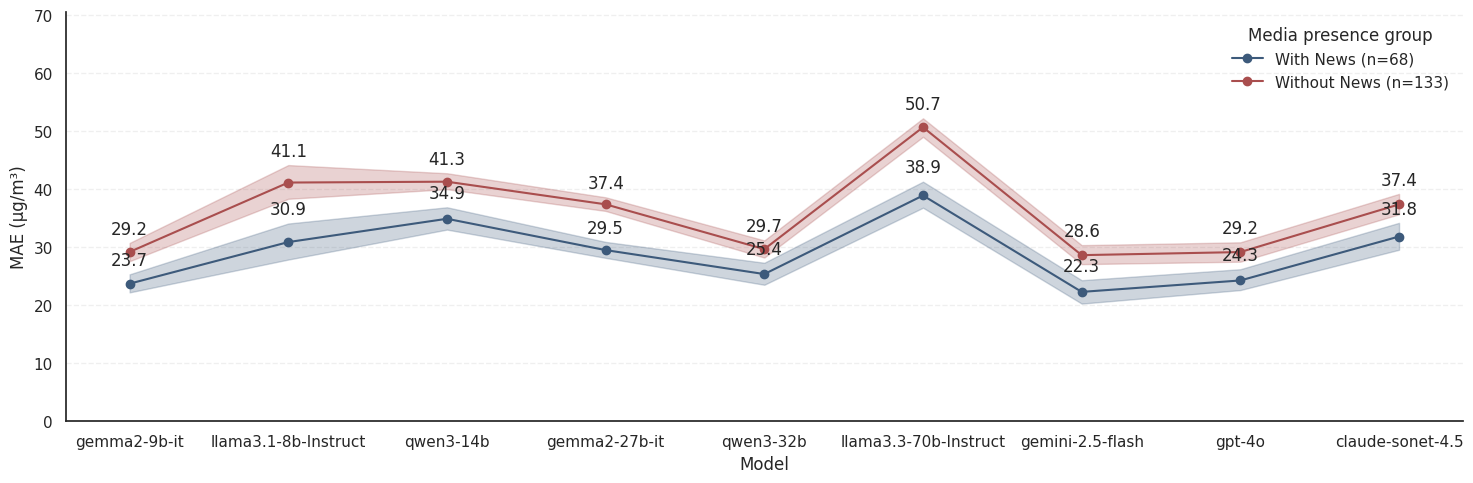

In [60]:
latexify(columns=2, fig_height=5.0, fig_width=15)
sns.set_theme(style="white")

# 1) Mean ± SE band
plot_news_mae_mean_band(
    metrics_df,
    wiki_news_df,
    err_type="se",
    news_count_threshold=NEWS_COUNT_THRESHOLD,
    # save_path="media_mae_mean_band_se.pdf",
)

# 2) Mean with parametric 95% CI band
plot_news_mae_mean_band(
    metrics_df,
    wiki_news_df,
    err_type="param_ci",
    news_count_threshold=NEWS_COUNT_THRESHOLD,
    # save_path="media_mae_mean_band_ci.pdf",
)

# 3) Mean with bootstrap 95% CI band
plot_news_mae_mean_band(
    metrics_df,
    wiki_news_df,
    err_type="boot_ci",
    news_count_threshold=NEWS_COUNT_THRESHOLD,
    # save_path="media_mae_mean_band_boot_ci.pdf",
)


In [41]:
import numpy as np

def matched_city_mae_both(
    long_df,
    n_repeats=2000,
    random_state=0,
):
    """
    long_df: subset of news_stats_long for ONE model.
             Must have columns: ['abs_error', 'Media Presence Group', 'city'].

    Returns:
        - MAE_high (original high-news MAE)
        - MAE_low_mean (mean over matched low-news bootstraps)
        - bootstrap CI for both groups
        - bootstrap CI for the difference (Low − High)
    """
    rng = np.random.default_rng(random_state)

    high = long_df[long_df["Media Presence Group"] == "High News"]
    low  = long_df[long_df["Media Presence Group"] == "Low News"]

    cities_high = high["city"].unique()
    cities_low  = low["city"].unique()

    n_high_cities = len(cities_high)

    # --- baseline MAE (no resampling) ---
    mae_high = high["abs_error"].mean()

    # for high-news bootstrap we resample rows
    high_errors = high["abs_error"].to_numpy()
    n_high_rows = len(high_errors)

    high_boot = []
    low_boot  = []

    for _ in range(n_repeats):
        # High-news bootstrap (rows with replacement)
        idx_high = rng.integers(0, n_high_rows, size=n_high_rows)
        mae_high_b = high_errors[idx_high].mean()
        high_boot.append(mae_high_b)

        # Low-news: sample SAME number of cities as high-news (without replacement)
        sampled_low_cities = rng.choice(
            cities_low,
            size=n_high_cities,
            replace=False
        )
        low_sample = low[low["city"].isin(sampled_low_cities)]
        mae_low_b = low_sample["abs_error"].mean()
        low_boot.append(mae_low_b)

    high_boot = np.array(high_boot)
    low_boot  = np.array(low_boot)
    diffs     = low_boot - high_boot

    return {
        # point estimates
        "mae_high": mae_high,
        "mae_low_mean": low_boot.mean(),

        # bootstrap CI for each group
        "high_ci_low": np.percentile(high_boot, 2.5),
        "high_ci_high": np.percentile(high_boot, 97.5),
        "low_ci_low": np.percentile(low_boot, 2.5),
        "low_ci_high": np.percentile(low_boot, 97.5),

        # diff distribution (Low − High), in case you want it in a table
        "diff_mean": diffs.mean(),
        "diff_ci_low": np.percentile(diffs, 2.5),
        "diff_ci_high": np.percentile(diffs, 97.5),

        "n_high_cities": n_high_cities,
        "n_low_cities_total": len(cities_low),
    }

In [42]:
matched_rows = []

for model_name in model_dfs.keys():
    df_model = news_stats_long[news_stats_long["Model"] == model_name]

    res = matched_city_mae_both(
        df_model,
        n_repeats=2000,
        random_state=0
    )

    # -------- High News row (with bootstrap CI) --------
    matched_rows.append({
        "Model": model_name,
        "Media Presence Group": "High News",
        "MAE": res["mae_high"],
        "MAE_se": np.nan,
        "MAE_ci_low_param": np.nan,
        "MAE_ci_high_param": np.nan,
        "MAE_ci_low_boot": res["high_ci_low"],
        "MAE_ci_high_boot": res["high_ci_high"],
    })

    # -------- Low News row (matched 68-city MAE with bootstrap CI) --------
    matched_rows.append({
        "Model": model_name,
        "Media Presence Group": "Low News",
        "MAE": res["mae_low_mean"],
        "MAE_se": np.nan,
        "MAE_ci_low_param": np.nan,
        "MAE_ci_high_param": np.nan,
        "MAE_ci_low_boot": res["low_ci_low"],
        "MAE_ci_high_boot": res["low_ci_high"],
    })

matched_df = pd.DataFrame(matched_rows)

# add MAE_Difference (Low - High)
pivot_diff_matched = matched_df.pivot(
    index="Model",
    columns="Media Presence Group",
    values="MAE"
)
pivot_diff_matched["MAE_Difference"] = (
    pivot_diff_matched["Low News"] - pivot_diff_matched["High News"]
)
matched_df = matched_df.merge(
    pivot_diff_matched["MAE_Difference"],
    on="Model",
    how="left"
)

# enforce same model order
model_order = list(model_dfs.keys())
matched_df["Model"] = pd.Categorical(
    matched_df["Model"],
    categories=model_order,
    ordered=True
)
matched_df = matched_df.sort_values("Model")

In [45]:
def plot_news_mae_bar_with_ci(
    matched_df,
    wiki_news_df,
    news_count_threshold=0,
    save_path=None,
    legend_labels=None,
):
    df = matched_df.copy()

    groups = ["High News", "Low News"]
    colors = {
        "High News": "#3D5A7B",
        "Low News": "#A94E4E",
    }

    # ----- legend labels -----
    if legend_labels is None:
        n_high = wiki_news_df[
            wiki_news_df["media_count"] > news_count_threshold
        ]["city"].nunique()
        n_low_total = wiki_news_df[
            wiki_news_df["media_count"] <= news_count_threshold
        ]["city"].nunique()

        legend_labels = {
            "High News": f"With News (n={n_high})",
            "Low News": f"Without News (n={n_high}, matched from {n_low_total})",
        }

    # ----- x axis -----
    model_order = list(df["Model"].cat.categories)
    df = df.sort_values("Model")
    x = np.arange(len(model_order))  # one position per model

    fig, ax = plt.subplots(1, 1)

    # panel label
    ax.text(
        -0.06, 1.05,
        "(a)",
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="left",
    )

    # vertical offset for numeric labels (relative to y-range)
    y_min = np.nanmin(df["MAE_ci_low_boot"])
    y_max = np.nanmax(df["MAE_ci_high_boot"])
    y_range = y_max - y_min
    text_offset = 0.02 * y_range

    # ----- bar plot with error bars -----
    width = 0.35  # bar width

    for i, group in enumerate(groups):
        g = df[df["Media Presence Group"] == group]
        g = g.set_index("Model").loc[model_order]

        y_mean = g["MAE"].to_numpy()
        ci_low = g["MAE_ci_low_boot"].to_numpy()
        ci_high = g["MAE_ci_high_boot"].to_numpy()

        # asymmetric error bars
        err_lower = y_mean - ci_low
        err_upper = ci_high - y_mean
        yerr = np.vstack([err_lower, err_upper])

        # x positions for this group
        x_pos = x - width / 2 + i * width

        bars = ax.bar(
            x_pos,
            y_mean,
            width=width,
            color=colors[group],
            label=legend_labels[group],
            yerr=yerr,
            capsize=3,
            linewidth=0.8,
            edgecolor="black",
        )

        # numeric MAE labels above error bar
        for xi, yi, eu in zip(x_pos, y_mean, err_upper):
            ax.text(
                xi,
                yi + eu + text_offset,
                f"{yi:.1f}",
                ha="center",
                va="bottom",
            )

    # ----- axes & legend -----
    ax.set_xticks(x)
    ax.set_xticklabels(model_order)
    ax.set_ylabel("MAE (µg/m³)")
    ax.set_xlabel("Model")

    ax.legend(title="Media presence group", frameon=False)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.set_axisbelow(True)

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, format="pdf", bbox_inches="tight")

    plt.show()

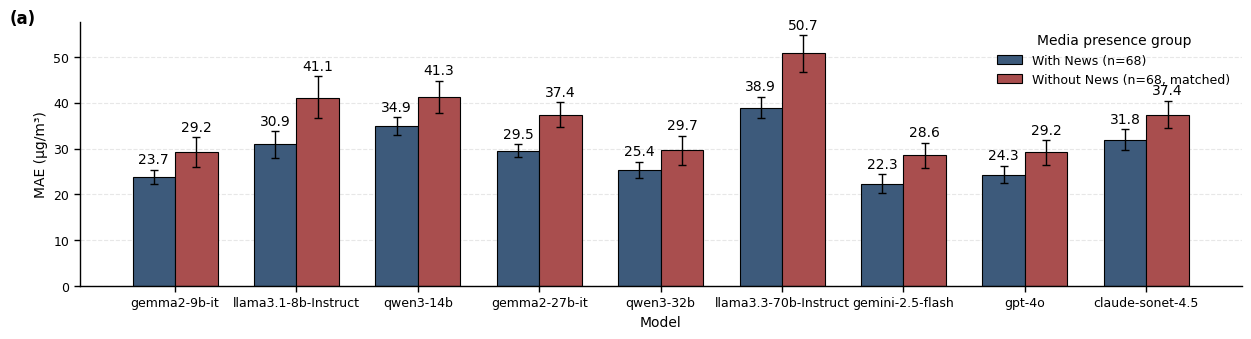

In [49]:
legend_labels_matched = {
    "High News": "With News (n=68)",
    "Low News":  "Without News (n=68, matched)",
}

latexify(columns=2, fig_height=3.5, fig_width=12.5)

plot_news_mae_bar_with_ci(
    matched_df=matched_df,
    wiki_news_df=None,   
    legend_labels=legend_labels_matched,
    save_path="news_matched_boot_ci.pdf",
)


In [30]:
def plot_news_mae_mean_band(
    matched_df,
    wiki_news_df,
    news_count_threshold=0,
    save_path=None,
    legend_labels=None,
):
    df = matched_df.copy()

    groups = ["High News", "Low News"]
    colors = {
        "High News": "#3D5A7B",
        "Low News": "#A94E4E",
    }

    # ----- legend labels -----
    if legend_labels is None:
        n_high = wiki_news_df[
            wiki_news_df["media_count"] > news_count_threshold
        ]["city"].nunique()
        n_low_total = wiki_news_df[
            wiki_news_df["media_count"] <= news_count_threshold
        ]["city"].nunique()

        legend_labels = {
            "High News": f"With News (n={n_high})",
            "Low News": f"Without News (n={n_high}, matched from {n_low_total})",
        }

    # ----- x axis -----
    model_order = list(df["Model"].cat.categories)
    df = df.sort_values("Model")
    x = np.arange(len(model_order))

    fig, ax = plt.subplots(1, 1)

    ax.text(
        -0.06, 1.05,
        "(a)",
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="left"
    )


    # vertical offset for text (relative to y-range)
    y_range = (
        np.nanmax(df["MAE_ci_high_boot"]) -
        np.nanmin(df["MAE_ci_low_boot"])
    )
    text_offset = 0.04 * y_range

    for group in groups:
        g = df[df["Media Presence Group"] == group]
        g = g.set_index("Model").loc[model_order]

        y_mean = g["MAE"].to_numpy()
        y_low  = g["MAE_ci_low_boot"].to_numpy()
        y_high = g["MAE_ci_high_boot"].to_numpy()

        ax.plot(
            x,
            y_mean,
            marker="o",
            linestyle="-",
            color=colors[group],
            label=legend_labels[group],
        )

        ax.fill_between(
            x,
            y_low,
            y_high,
            color=colors[group],
            alpha=0.25,
        )

        # ----- numeric MAE labels near points -----
        for xi, yi in zip(x, y_mean):
            if group == "High News":
                # blue → below
                ax.text(
                    xi,
                    yi - text_offset,
                    f"{yi:.1f}",
                    ha="center",
                    va="top",
                )
            else:
                # red → above
                ax.text(
                    xi,
                    yi + text_offset,
                    f"{yi:.1f}",
                    ha="center",
                    va="bottom",
                )

    ax.set_xticks(x)
    ax.set_xticklabels(model_order)
    ax.set_ylabel("MAE (µg/m³)")
    ax.set_xlabel("Model")

    ax.legend(title="Media presence group", frameon=False)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.set_axisbelow(True)

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, format="pdf", bbox_inches="tight")

    plt.show()

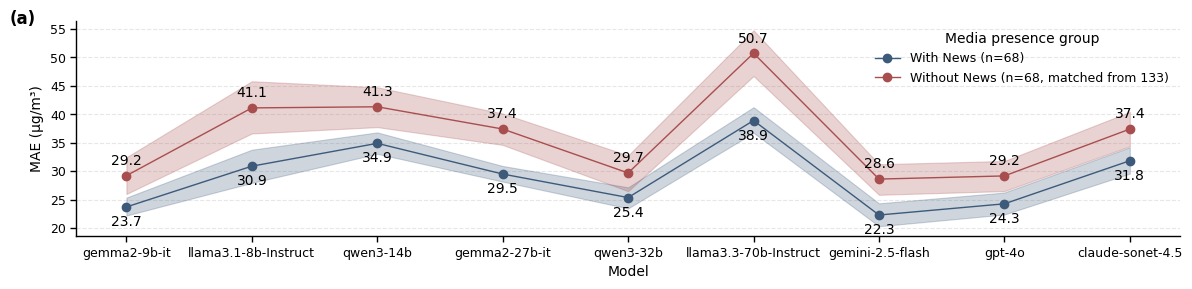

In [31]:
latexify(columns=2, fig_height=3.0,fig_width=12)

plot_news_mae_mean_band(
    matched_df,
    wiki_news_df=wiki_news_df,
    news_count_threshold=NEWS_COUNT_THRESHOLD,
    save_path="news_matched_mean_band_ci.pdf",
)


In [61]:
for model_name in model_dfs.keys():
    # original low-news MAE from full metrics_df
    orig = metrics_df[
        (metrics_df["Model"] == model_name) &
        (metrics_df["Media Presence Group"] == "Low News")
    ]["MAE"].iloc[0]

    # matched low-news MAE from matched_df
    matched = matched_df[
        (matched_df["Model"] == model_name) &
        (matched_df["Media Presence Group"] == "Low News")
    ]["MAE"].iloc[0]

    print(model_name, f"orig={orig:.4f}, matched={matched:.4f}, diff={matched-orig:.4f}")

gemma2-9b-it orig=29.1887, matched=29.2149, diff=0.0262
llama3.1-8b-Instruct orig=41.1475, matched=41.1325, diff=-0.0151
qwen3-14b orig=41.2953, matched=41.3290, diff=0.0337
gemma2-27b-it orig=37.3937, matched=37.4201, diff=0.0264
qwen3-32b orig=29.6684, matched=29.6956, diff=0.0272
llama3.3-70b-Instruct orig=50.6814, matched=50.7458, diff=0.0644
gemini-2.5-flash orig=28.6331, matched=28.6186, diff=-0.0145
gpt-4o orig=29.1652, matched=29.1720, diff=0.0069
claude-sonet-4.5 orig=37.3814, matched=37.4115, diff=0.0301


#### Wikipedia page content

In [ ]:
rows = []

for model_name, model_df in model_dfs.items():
    merged = pd.merge(model_df, gt_df, on=['city', 'state', 'year', 'month'], how='inner')
    merged = pd.merge(merged, wiki_news_df[['city', 'state', 'wiki_len']], on=['city', 'state'], how='left')
    merged = merged.dropna(subset=['ground_truth_pm25', 'pm2.5'])

    merged['wiki_len'] = merged['wiki_len'].fillna(0)

    print(f"=== {model_name} ===")
    print("Group <5000 sample count:", (merged['wiki_len'] < 5000).sum())
    print("Group >=5000 sample count:", (merged['wiki_len'] >= 5000).sum())

    # Divide into two groups
    low_wiki_df = merged[merged['wiki_len'] < 5000]
    high_wiki_df = merged[merged['wiki_len'] >= 5000]

    # Compute metrics
    low_metrics = compute_metrics(low_wiki_df)
    high_metrics = compute_metrics(high_wiki_df)

    # Format results
    row = {'Model': model_name}
    for k, v in low_metrics.items():
        row[f'Wiki <5000: {k}'] = v
    for k, v in high_metrics.items():
        row[f'Wiki >=5000: {k}'] = v

    rows.append(row)

# Final DataFrame
wiki_len_compare_df = pd.DataFrame(rows)

wiki_len_compare_df

In [23]:
rows = []

for model_name, model_df in model_dfs.items():
    merged = pd.merge(model_df, gt_df, on=['city', 'state', 'year', 'month'], how='inner')
    
    merged = pd.merge(merged, wiki_news_df[['city', 'state', 'media_count']], on=['city', 'state'], how='left')
    merged['media_count'] = merged['media_count'].fillna(0) 
    
    merged = merged.dropna(subset=['ground_truth_pm25', 'pm2.5'])
    
    with_news_df = merged[merged['media_count'] > 1]
    without_news_df = merged[merged['media_count'] <= 1]
    
    with_news_metrics = compute_metrics(with_news_df)
    without_news_metrics = compute_metrics(without_news_df)
    
    row = {'Model': model_name}
    for k, v in with_news_metrics.items():
        row[f'With News: {k}'] = v
    for k, v in without_news_metrics.items():
        row[f'Without News: {k}'] = v
        
    rows.append(row)

final_media_df = pd.DataFrame(rows)

In [ ]:
final_media_df